In [1]:
import sys
import numpy as np
import random
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from numpy.random import seed
seed(42)

import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
K.set_floatx('float16')
K.set_epsilon(1e-12)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080 Laptop GPU, compute capability 8.6


#### Importo il dataset

In [2]:
text = open("data/guida_galattica_per_gli_autostoppisti.txt", encoding='utf-8').read()
text2 = open("data/ristorante_al_termine_dell_universo.txt", encoding='utf-8').read()
text3 = open("data/la_vita_l_universo_e_tutto_quanto.txt", encoding='utf-8').read()
text4 = open("data/addio_e_grazie_per_tutto_il_pesce.txt", encoding='utf-8').read()
text5 = open("data/praticamente_innocuo.txt    ", encoding='utf-8').read()

text += ' ' + text2 + ' ' + text3 + ' ' + text4 + ' ' + text5

#### Preprocessing del dataset

In [3]:
text = text.replace('\n', ' ')
text = text.replace('\x0c', ' ')
text = text.replace("E'", 'È')
text = text.replace("&", 'E')
text = text.replace('–', '-')
text = text.replace('—', '-')
text = text.replace('-', ' ')
text = text.replace("‘", " ")
text = text.replace('’', " ")
text = text.replace('“', ' ')
text = text.replace('”', ' ')
text = text.replace('…', ' ')
text = text.replace("'", " ")
text = text.replace('.', ' ')
text = text.replace(',', ' ')
text = text.replace(';', ' ')
text = text.replace(':', ' ')
text = text.replace('!', ' ')
text = text.replace('?', ' ')
text = text.replace(')', ' ')
text = text.replace('(', ' ')
text = text.replace(']', ' ')
text = text.replace('[', ' ')
text = text.replace('}', ' ')
text = text.replace('{', ' ')
text = text.replace('#', ' ')
text = text.replace('§', ' ')
text = text.replace('°', ' ')
text = text.replace('"', ' ')
text = text.replace('/', ' ')
text = text.replace('=', ' ')
text = text.replace('»', ' ')
text = text.replace('«', ' ')
text = text.replace('ª', ' ')
text = text.replace('™', ' ')
text = text.upper()

In [4]:
print('Lunghezza del testo:', len(text))
print('(circa) numero di parole:', int(len(text)/6))
print('Primi mille caratteri:\n', text[0:1000], '\n')

Lunghezza del testo: 1650075
(circa) numero di parole: 275012
Primi mille caratteri:
 LONTANO  NEI DIMENTICATI SPAZI NON SEGNATI NELLE CARTE GEOGRAFICHE DELL ESTREMO LIMITE DELLA SPIRALE OVEST DELLA GALASSIA  C È UN PICCOLO E INSIGNIFICANTE SOLE GIALLO  A ORBITARE INTORNO A ESSO  ALLA DISTANZA DI CENTOQUARANTANOVE MILIONI DI CHILOMETRI  C È UN PICCOLO  TRASCURABILISSIMO PIANETA AZZURRO VERDE  LE CUI FORME DI VITA  DISCENDENTI DALLE SCIMMIE  SONO COSÌ INCREDIBILMENTE PRIMITIVE CHE CREDONO ANCORA CHE GLI OROLOGI DA POLSO DIGITALI SIANO UN OTTIMA INVENZIONE  QUESTO PIANETA HA  O MEGLIO AVEVA  UN FONDAMENTALE PROBLEMA  LA MAGGIOR PARTE DEI SUOI ABITANTI ERANO INFATTI AFFLITTI DA UNA QUASI COSTANTE INFELICITÀ  PER RISOLVERE IL PROBLEMA DI QUESTA INFELICITÀ FURONO SUGGERITE VARIE PROPOSTE  MA QUESTE PER LO PIÙ CONCERNEVANO LO SCAMBIO CONTINUO DI PEZZETTI DI CARTA VERDE  UN FATTO INDUBBIAMENTE STRANO  VISTO CHE AD ESSERE INFELICI NON ERANO I PEZZETTI DI CARTA VERDE  MA GLI ABITANTI DEL PIANET

#### lista ordinata di tutto i simboli utilizzati

In [5]:
chars = sorted(list(set(text))) 

char_indices = dict((c, i) for i, c in enumerate(chars))# utile per conversione da simbolo a indice
print(len(char_indices), 'caratteri unici')

print(char_indices)

49 caratteri unici
{' ': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'J': 20, 'K': 21, 'L': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'Q': 27, 'R': 28, 'S': 29, 'T': 30, 'U': 31, 'V': 32, 'W': 33, 'X': 34, 'Y': 35, 'Z': 36, '²': 37, 'À': 38, 'Â': 39, 'È': 40, 'É': 41, 'Ì': 42, 'Î': 43, 'Ñ': 44, 'Ò': 45, 'Ö': 46, 'Ù': 47, 'Π': 48}


In [6]:
text = text.replace(chars[-12], '2')
chars[-12] = '2'
text = text.replace(chars[-10], 'À')
chars[-10] = 'À'
text = text.replace(chars[-9], 'É')
chars[-9] = 'É'
text = text.replace(chars[-6], 'Ì')
chars[-6] = 'Ì'
text = text.replace(chars[-5], 'N')
chars[-5] = 'N'
text = text.replace(chars[-3], 'Ò')
chars[-3] = 'Ò'
text = text.replace(chars[-1], ' ')
chars[-1] = ' '

chars = sorted(list(set(chars)))

char_indices = dict((c, i) for i, c in enumerate(chars))
print(len(char_indices), 'caratteri unici')

indices_char = dict((i, c) for i, c in enumerate(chars))

print(char_indices)

42 caratteri unici
{' ': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'A': 11, 'B': 12, 'C': 13, 'D': 14, 'E': 15, 'F': 16, 'G': 17, 'H': 18, 'I': 19, 'J': 20, 'K': 21, 'L': 22, 'M': 23, 'N': 24, 'O': 25, 'P': 26, 'Q': 27, 'R': 28, 'S': 29, 'T': 30, 'U': 31, 'V': 32, 'W': 33, 'X': 34, 'Y': 35, 'Z': 36, 'À': 37, 'É': 38, 'Ì': 39, 'Ò': 40, 'Ù': 41}


In [7]:
text = text.replace('  ', ' ')

#### Creazione fase temporale

In [8]:
max_len = 48
step = 4 
sentences = []
next_chars = []
for i in range(0, len(text) - max_len, step):
    sentences.append(text[i: i + max_len])
    next_chars.append(text[i + max_len])
print('sequenze di testo generate:', len(sentences))

sequenze di testo generate: 399437


#### Creazione di X e Y

In [9]:
print('generazione dei vettori x di input e y di output')
x = np.zeros((len(sentences), max_len, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

generazione dei vettori x di input e y di output


#### Creazione architettura con celle LSTM e compilazione modello

In [10]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(max_len, len(chars))))
model.add(LSTM(256))
model.add(Dense(512, activation='swish'))
model.add(Dense(len(chars), activation='softmax', dtype='float32'))
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 512)           1136640   
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 42)                21546     
Total params: 2,077,226
Trainable params: 2,077,226
Non-trainable params: 0
_________________________________________________________________


#### Tramite il backand di keras  imposto un learning rate dinamico che mi consente di modificarlo durante l'addestramento se il nostro learning rate sale o scende troppo

In [1]:
class TrainingManagerCB(Callback):
    decay      = True
    start_lr   = 0.003
    start_lr_2 = 0.0015
    max_lr     = 0.001
    min_lr     = 0.0001

    def on_train_begin(self, logs=None):
        K.set_value(self.model.optimizer.lr, self.start_lr)

    def on_epoch_end(self, epoch, logs=None):
        actual_learning_rate = K.eval(self.model.optimizer.lr)

        if epoch == 19:
            K.set_value(self.model.optimizer.lr, self.max_lr)
        if epoch == 9:
            K.set_value(self.model.optimizer.lr, self.start_lr_2)
        elif epoch > 29:
            if self.decay:
                K.set_value(self.model.optimizer.lr, actual_learning_rate - (actual_learning_rate * 0.06))
            else:
                K.set_value(self.model.optimizer.lr, actual_learning_rate + (actual_learning_rate * 0.18))

        print('epoca:', str(epoch + 1) + '/' + str(epochs),
              ' -  lr:%f' % actual_learning_rate,
              ' -  loss:', logs['loss'])

        actual_learning_rate = K.eval(self.model.optimizer.lr)
        if actual_learning_rate < self.min_lr:
            self.decay = False
            self.max_lr -= self.max_lr * 0.1
        elif actual_learning_rate > self.max_lr:
            self.decay = True

        if epoch < 101:
            step = 100
        elif epoch < 351:
            step = 75
        else:
            step = 50
        if (epoch + 1) % step == 0:
            start_index = random.randint(0, len(text) - max_len - 1)
            generated = ''
            sentence = text[start_index: start_index + max_len] #crea un chunk di 48 caratteri a partire da un indice a caso
            generated += sentence
            print('-------------------                                           \n',
                  'frase di partenza:', sentence, '-------------------\nfrase generata:')
            for i in range(250):
                x_pred = np.zeros((1, max_len, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = self.model.predict(x_pred, verbose=0)[0]
                next_index = np.argmax(preds)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()

                if (i+1) % 50 == 0:
                    sys.stdout.write('\n')
            print('\n-------------------')

NameError: name 'Callback' is not defined

#### lancio l'addestramento del modello 

In [12]:
tm = TrainingManagerCB()

batches = 1024
epochs = 200

print('inizio addestramento.\n', epochs, 'epoche (', len(x), 'esempi, analizzati', batches, 'alla volta su', int(len(x) / batches) + 1,
      'aggiornamenti dei '
      'parametri per epoca )')

history = model.fit(x, y,
          batch_size=batches, 
          epochs=epochs,
          callbacks=tm,
          verbose=0)
print('\n\fFine addestramento.')

inizio addestramento.
 200 epoche ( 399437 esempi, analizzati 1024 alla volta su 391 aggiornamenti dei parametri per epoca )
epoca: 1/200  -  lr:0.003000  -  loss: 2.3069422245025635
epoca: 2/200  -  lr:0.003000  -  loss: 1.7947309017181396
epoca: 3/200  -  lr:0.003000  -  loss: 1.676109790802002
epoca: 4/200  -  lr:0.003000  -  loss: 2.3268930912017822
epoca: 5/200  -  lr:0.003000  -  loss: 2.1641643047332764
epoca: 6/200  -  lr:0.003000  -  loss: 2.0655038356781006
epoca: 7/200  -  lr:0.003000  -  loss: 2.001927614212036
epoca: 8/200  -  lr:0.003000  -  loss: 1.9529647827148438
epoca: 9/200  -  lr:0.003000  -  loss: 1.9090536832809448
epoca: 10/200  -  lr:0.003000  -  loss: 1.8767681121826172
epoca: 11/200  -  lr:0.001500  -  loss: 1.8332265615463257
epoca: 12/200  -  lr:0.001500  -  loss: 1.8174374103546143
epoca: 13/200  -  lr:0.001500  -  loss: 1.799990177154541
epoca: 14/200  -  lr:0.001500  -  loss: 1.786354899406433
epoca: 15/200  -  lr:0.001500  -  loss: 1.770458459854126
epoc

#### Illustrazione dell errore in fase di addestramento

<Figure size 1440x864 with 0 Axes>

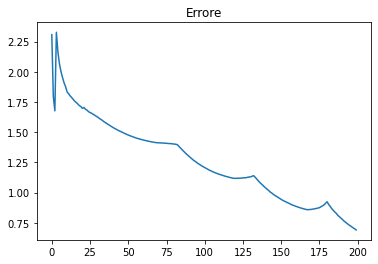

In [13]:
# visualizzazione addestramento
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Errore')
ax.plot(history.history['loss'])
plt.show()

#### Riaddestro una seconda volta il modello

In [14]:
epochs = 500
print('secondo addestramento.\n', epochs, 'epoche (', len(x), 'esempi, analizzati', batches, 'alla volta su', int(len(x) / batches) + 1,
      'aggiornamenti dei parametri per epoca )')
history = model.fit(x, y,
          batch_size=batches, 
          epochs=epochs,
          callbacks=tm,
          initial_epoch=200,
          verbose=0)
print('\n\nfine addestramento.')

secondo addestramento.
 500 epoche ( 399437 esempi, analizzati 1024 alla volta su 391 aggiornamenti dei parametri per epoca )
epoca: 201/500  -  lr:0.003000  -  loss: 1.3262683153152466
epoca: 202/500  -  lr:0.002820  -  loss: 1.1670067310333252
epoca: 203/500  -  lr:0.002651  -  loss: 1.1046245098114014
epoca: 204/500  -  lr:0.002492  -  loss: 1.0702108144760132
epoca: 205/500  -  lr:0.002342  -  loss: 1.0328928232192993
epoca: 206/500  -  lr:0.002202  -  loss: 0.9926525354385376
epoca: 207/500  -  lr:0.002070  -  loss: 0.9658905267715454
epoca: 208/500  -  lr:0.001945  -  loss: 0.9345508217811584
epoca: 209/500  -  lr:0.001829  -  loss: 0.8986601233482361
epoca: 210/500  -  lr:0.001719  -  loss: 0.87087482213974
epoca: 211/500  -  lr:0.001616  -  loss: 0.8366800546646118
epoca: 212/500  -  lr:0.001519  -  loss: 0.8039748668670654
epoca: 213/500  -  lr:0.001428  -  loss: 0.7793330550193787
epoca: 214/500  -  lr:0.001342  -  loss: 0.7491719722747803
epoca: 215/500  -  lr:0.001262  -  l

#### Illustrazione dell errore sul secondo addestramento e come si puo notare dal grafico abbiamo ragiunto il massimo che possiamo

<Figure size 1440x864 with 0 Axes>

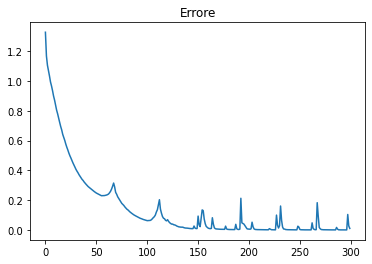

In [15]:
# visualizzazione secondo addestramento
plt.figure(figsize=(20,12))
f, ax = plt.subplots()
ax.set_title('Errore')
ax.plot(history.history['loss'])
plt.show()

#### Generazione di 400 lettere in seguito ad una porzione di testo random dato come input 

In [ ]:
start_index = random.randint(0, len(text) - max_len - 1)
sentence = text[start_index: start_index + max_len]
sentence_appo = sentence[:]#crea un chunk di 48 caratteri a partire da un indice a caso

print('frase di partenza:\n', sentence, '\n\n\nfrase generata:\n')

for i in range(400):
    x_pred = np.zeros((1, max_len, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = np.argmax(preds)
    next_char = indices_char[next_index]

    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()

print('\n-------------------')

## Per motivi computazionali non e' stato possibile avere dei risultati ottimali in quanto ho deciso di non stampare le previsioni del modello, il notebook e stato creato a solo scopo di mostrare le competenze acquisite per quanto riguarda il NLP 